In [1]:
import torch
import torch.nn as nn
import yaml
import h5py
from utils import TransformerOperatorDataset
import torch.nn.functional as F
from tqdm import tqdm
import math
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import shutil

from models.pitt import PhysicsInformedTokenTransformer
from models.pitt import StandardPhysicsInformedTokenTransformer

from models.oformer import Encoder1D, STDecoder1D, OFormer1D, PointWiseDecoder1D
from models.fno import FNO1d
from models.deeponet import DeepONet1D

import sys

from train_pitt import evaluate, get_transformer, get_data, get_neural_operator

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'

In [23]:
with open("./configs/pitt_config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
train_args = config['args']
prefix = train_args['flnm'] + "_" + train_args['data_name'].split("_")[0] + "_" + train_args['train_style'] + "_" + \
         train_args['embedding']
train_args['prefix'] = prefix
train_args['seed'] = 4

In [24]:
path = "{}{}_{}_{}".format(train_args['results_dir'], train_args['transformer'], train_args['neural_operator'], prefix)
f = h5py.File("{}{}".format(train_args['base_path'], train_args['data_name']), 'r')
model_name = train_args['flnm'] + '_{}'.format(train_args['transformer']) + "_{}.pt".format(train_args['seed'])
model_path = path + "/" + model_name

In [25]:
train_loader, val_loader, test_loader = get_data(f, train_args)


SEED: 4
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 476.04it/s]



NUMBER OF SAMPLES: 588
Processing data...


588it [00:00, 718.05it/s]



SEED: 4
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 673.35it/s]



NUMBER OF SAMPLES: 196
Processing data...


196it [00:00, 687.21it/s]



SEED: 4
Gathering data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 772.22it/s]



NUMBER OF SAMPLES: 196
Processing data...


196it [00:00, 732.98it/s]


In [26]:
neural_operator = get_neural_operator(train_args['neural_operator'], train_args)
transformer = get_transformer(train_args['transformer'], neural_operator, train_args)


USING NOVEL EMBEDDING


In [27]:
transformer.load_state_dict(torch.load(model_path)['model_state_dict'])

/tmp/ipykernel_43286/2077529672.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(model_path)['model_state_dict'])


<All keys matched successfully>

In [28]:
loss_fn = nn.L1Loss(reduction='mean')

In [29]:
test_value = evaluate(test_loader, transformer, loss_fn)

In [30]:
test_value

0.03032053168863058

In [31]:
(x0, y, grid, tokens, t) = list(test_loader)[1]

In [32]:
grid.shape

torch.Size([68, 100])

In [33]:
y_pred=transformer(grid.to(device=device), tokens.to(device=device), x0.to(device=device), t.to(device=device))

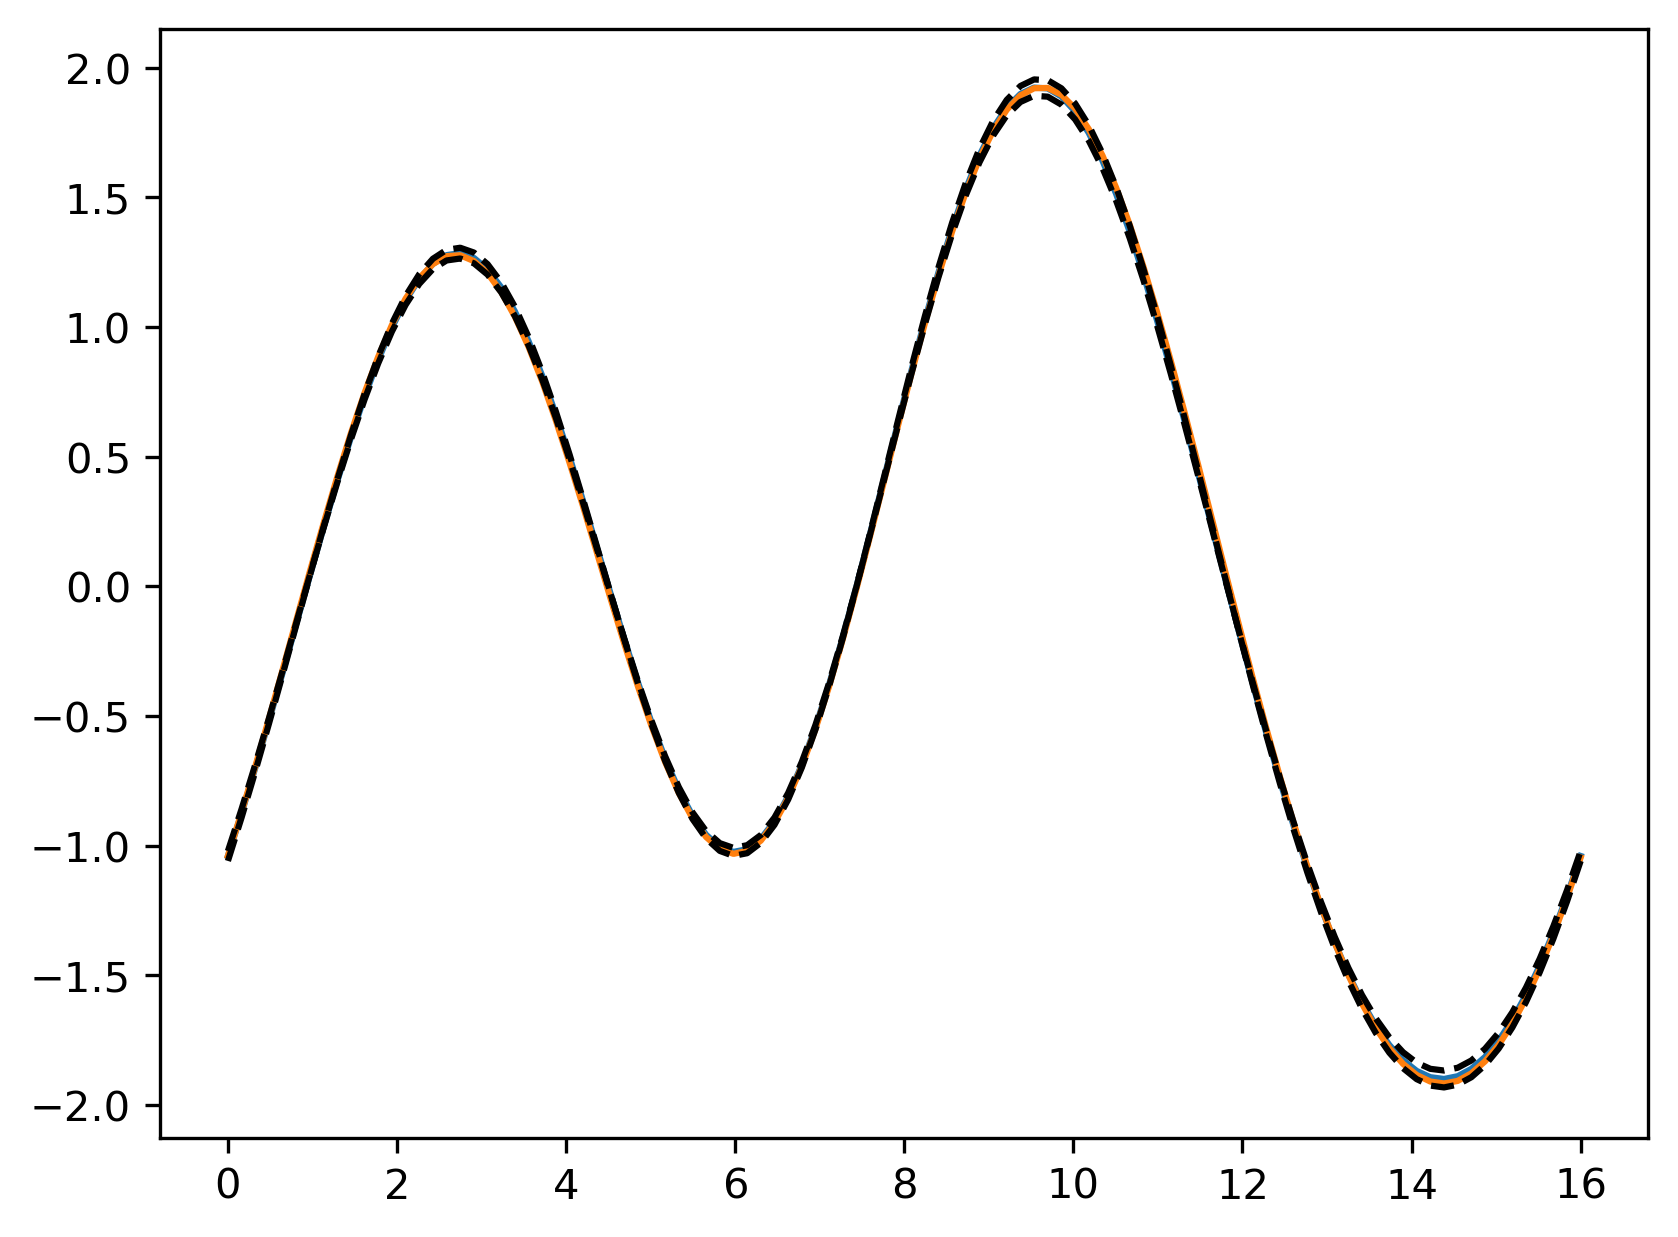

In [34]:
ibatch=1
fig=plt.figure(dpi=300)
plt.plot((grid[ibatch,:]).cpu(),(y[ibatch,:,0]).cpu())
plt.plot((grid[ibatch,:]).cpu(),((y_pred.detach()[ibatch,:])).cpu())
plt.plot((grid[ibatch,:]).cpu(),((x0[ibatch,:,:]).transpose(0,1)).cpu(),'k--')

In [52]:
y = y[...,0].to(device=device)    
# Compute the loss.
loss_fn(y_pred, y).item()

0.0025532743893563747

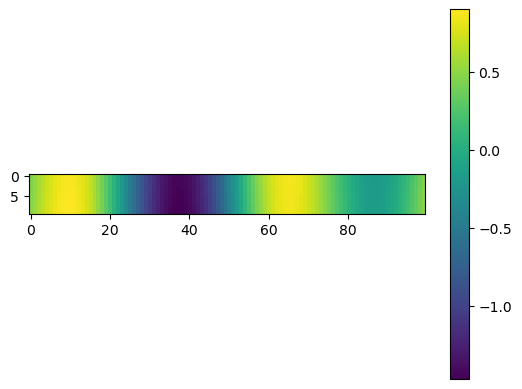

In [55]:
plt.imshow((x0[ibatch,:,:]).cpu())
plt.colorbar()